In [42]:
import os, sys
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c as c_light
from scipy.signal import find_peaks
from wakis import WakeSolver

sys.path.append('../garfield/')
from Genetic_algorithm import *
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm


### Testing the multiple resonator partially decayed function with two arbitrary resonators and wakelength

/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/malthera/miniconda3/envs/garfield-env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


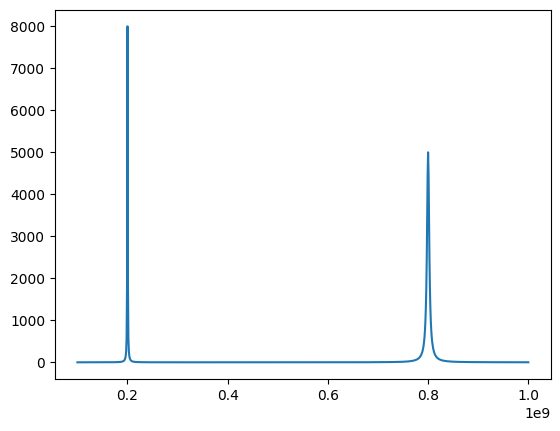

In [43]:
parameters ={   '1': [8e3, 200, 0.2e9], 
                '2': [5e3, 150, 0.8e9],
                }

frequency = np.linspace(0.1e9, 1e9, 1000)

result = n_Resonator_longitudinal_imp(frequency, parameters, wake_length=1e5)
plt.plot(frequency, result)

## Testing the GA and minimization functions of GARFIELD

##### {charge_param=1e-09; time_step_stability_factor=0.5; cond=1000; wakelength=10000; cpw=10}

In [44]:
# Importing impedance data
data_impedance = np.loadtxt('impedance.txt', comments='#', delimiter='\t')
frequency = data_impedance[:,0]*1e9
impedance = data_impedance[:,1] + 1j*data_impedance[:,2]

# Importing wake data
data_wake = np.loadtxt('wake.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]
time = np.array(data_wake[:,0])*1e-2/c_light

In [45]:
Nres = 2

""" Bounds on resonators parameters, it's possible to manually set them as well.
Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """

bounds = [(5e3, 10e3), (100, 5e3), (0.4e9, 1e9)]
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=100)

In [46]:
%%time
GA_model_scipy = GeneticAlgorithm(frequency, 
                                  impedance, 
                                  time, 
                                  wake, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredError,
                                  fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                 )

GA_model_scipy.run_geneticAlgorithm(maxiter=3000, 
                                    popsize=150, 
                                    tol=0.01, 
                                    mutation=(0.1, 0.5), 
                                    crossover_rate=0.8
                                   )
print(GA_model_scipy.warning)

Progress: [########################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        8.57e+03        |      200.21      |    5.480e+08     
    2     |        6.34e+03        |      175.26      |    8.166e+08     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 4.07 s, sys: 285 ms, total: 4.35 s
Wall time: 5.73 s


In [47]:
%%time
GA_model_scipy.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        8.54e+03        |      199.67      |    5.480e+08     
    2     |        6.33e+03        |      175.11      |    8.166e+08     
----------------------------------------------------------------------
CPU times: user 57.2 ms, sys: 927 µs, total: 58.2 ms
Wall time: 57.7 ms


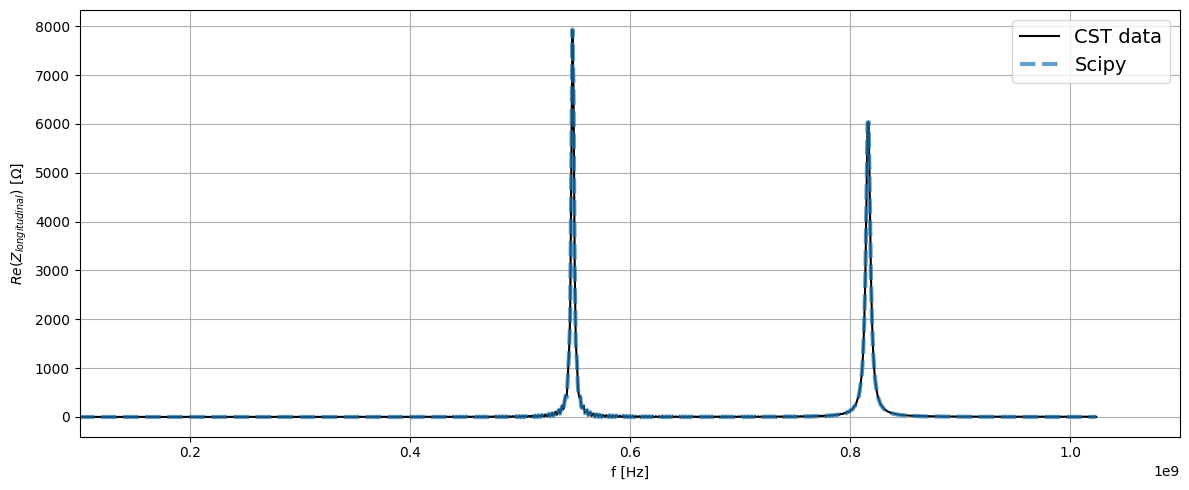

In [48]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.fitFunction(GA_model_scipy.frequency_data, dict(enumerate(GA_model_scipy.geneticParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

### Computing the wakefunction from the estimated resonators

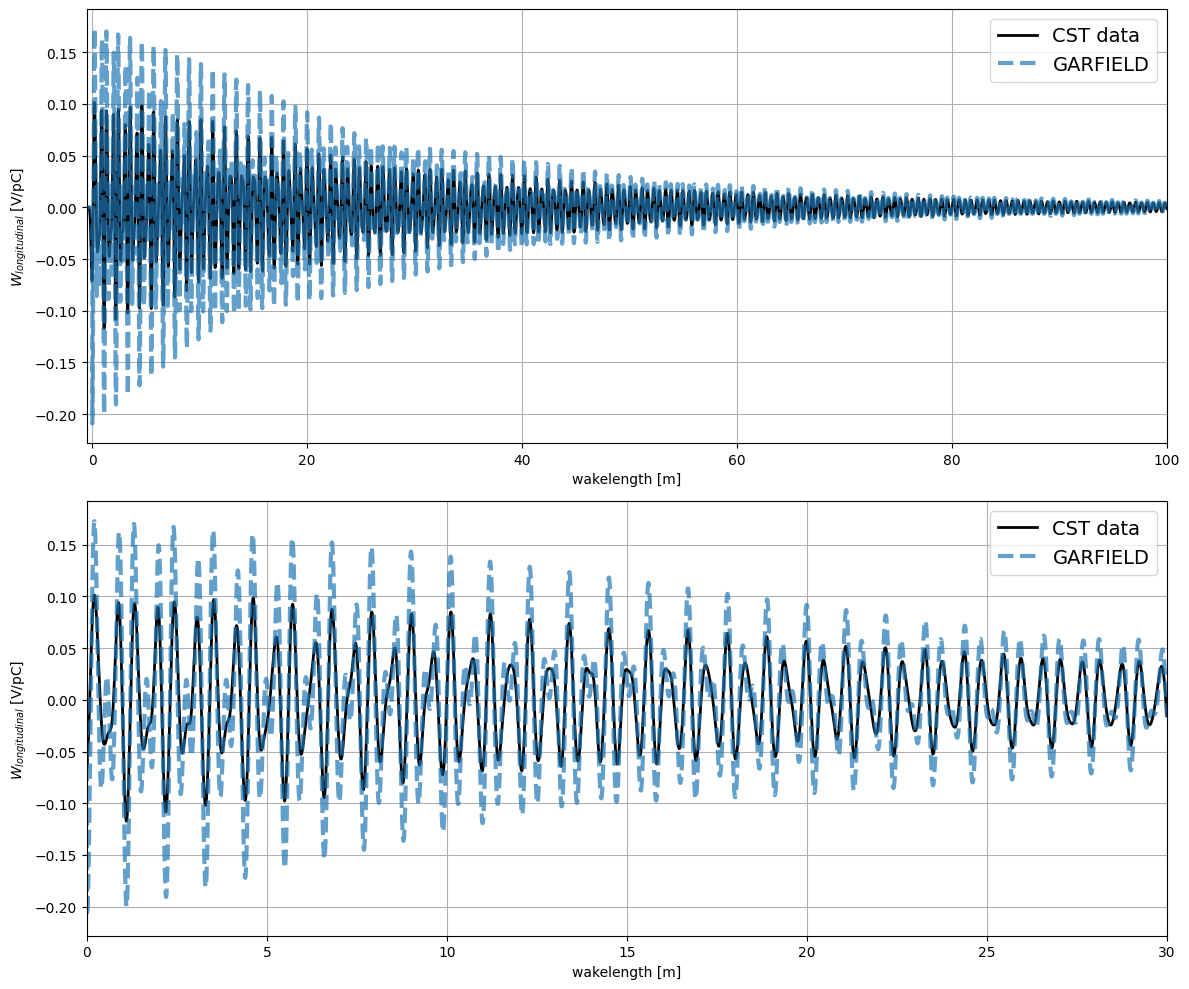

In [51]:
fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(12,10))

ax0.plot(GA_model_scipy.time_data*c_light, GA_model_scipy.wake_data, "black", lw=2, label='CST data')

ax0.plot(GA_model_scipy.time_data*c_light, -2*np.pi*n_Resonator_longitudinal_wake(GA_model_scipy.time_data,
                                                                   dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-13,
         lw = 3, linestyle='--', label='GARFIELD', alpha=0.7)

ax1.plot(GA_model_scipy.time_data*c_light, GA_model_scipy.wake_data, "black", lw=2, label='CST data')

ax1.plot(GA_model_scipy.time_data*c_light, -2*np.pi*n_Resonator_longitudinal_wake(GA_model_scipy.time_data,
                                                                   dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-13,
         lw = 3, linestyle='--', label='GARFIELD', alpha=0.7)

#ax1.set_xscale('log')

ax0.set_xlabel('wakelength [m]')
ax1.set_xlabel('wakelength [m]')

ax0.set_ylabel('$W_{longitudinal}$ [V/pC]')
ax1.set_ylabel('$W_{longitudinal}$ [V/pC]')

ax0.set_xlim(-0.5, 100)
ax1.set_xlim(0, 30)

ax0.legend(loc='best', fontsize=14)
ax1.legend(loc='best', fontsize=14)

ax0.grid()
ax1.grid()

fig.tight_layout()

### Computing the impedance of the computed wake data

## Own algorithm

In [9]:
def compute_impedance(WP_DATA, CHARGE_DATA, TIME_DATA, q=1e-9, beta=1.0, sigmaz=0.1, samples=1001):
    v = beta * c_light
    ds = np.mean(TIME_DATA[1:, 0]/100 - TIME_DATA[:-1, 0]/100)
    #fmax = v/sigmaz/2.928
    fmax = 1.0239144611436e9
    N = int((v / ds) // fmax * samples)

    # Interpolate charge data
    charge_data_interp = np.interp(TIME_DATA[:, 0]/100, CHARGE_DATA[:, 0]/100, CHARGE_DATA[:, 1] / q)
    # Perform Fourier transform
    ft_charge = np.fft.fft(charge_data_interp * v, n=N)
    ft_wake_potential = np.fft.fft(WP_DATA[:, 1] * 1e9, n=N)
    freq = np.fft.fftfreq(len(ft_wake_potential), ds / v)

    # Mask invalid frequencies
    mask = np.logical_and(freq >= 0, freq < fmax)
    ft_wake_potential_masked = ft_wake_potential[mask] * ds
    ft_charge_masked = ft_charge[mask] * ds
    freq_masked = freq[mask]  # positive frequencies

    # Compute impedance
    impedance = ft_wake_potential_masked / ft_charge_masked

    # Plot the Fourier transform
    plt.plot(freq_masked, np.abs(impedance))
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('Fourier Transform of data_potential')
    plt.show()

    peaks, peaks_height = find_peaks(np.abs(impedance), height=1e3, threshold=None)
    return impedance, freq_masked, peaks, peaks_height


In [58]:
# Compute the longitudinal wake function of the two resonators
wake_function_data = 0
wake_function_data = n_Resonator_longitudinal_wake(GA_model_scipy.time_data, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-13
wake_function_data = np.column_stack((GA_model_scipy.time_data*c_light, wake_function_data))

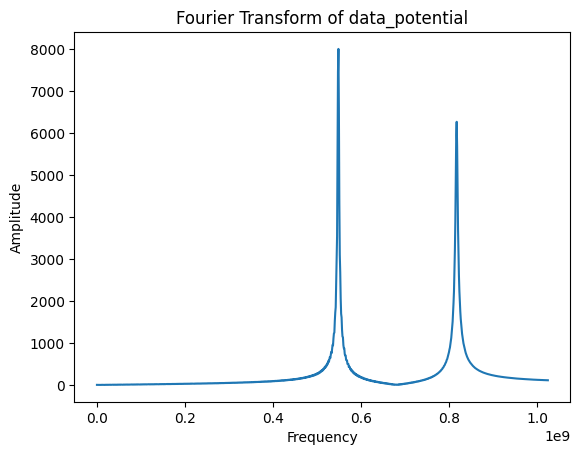

{'peak_heights': array([8003.35892208, 6267.58162952])}


In [59]:
# Import charge data
file_path_charge_distance = "/home/malthera/cernbox/Documents/Accelerator Cavity results/All outputs 100cpw cond100/charge_dist_dist.txt"
CD_COND1000 = np.loadtxt(file_path_charge_distance)/100

# Example usage:
impedance, freq_masked, peaks, peaks_height = compute_impedance(wake_function_data, CD_COND1000, data_wake)
print(peaks_height)


## WAKIS

Calculating longitudinal impedance Z...


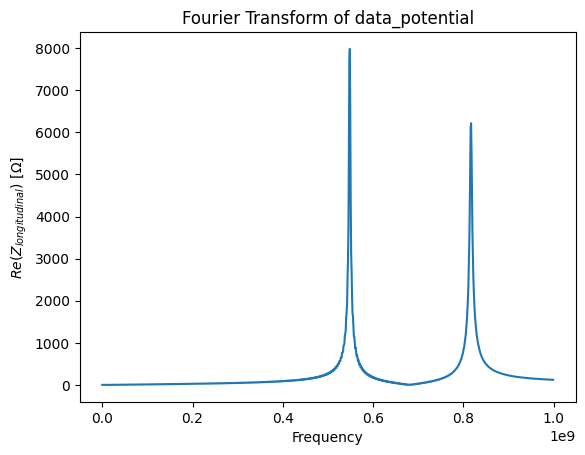

548308987.0322996 816970403.2648836 {'peak_heights': array([7980.61977459, 6215.80047304])}


In [62]:
#instantiating a class. An instance of the WakeSolver class.
wake_function_wakis = WakeSolver(q = 1e-9, sigmaz = 0.1)

#setting the wake potential and time data

wake_function_wakis.WP = wake_function_data[:, 1]

wake_function_wakis.s = data_wake[:,0] /100 #GOOD

wake_function_wakis.lambdas = np.interp(data_wake[:, 0], CD_COND1000[:, 0], CD_COND1000[:, 1] / 1e-9 *1e3)

# Computing the impedance using the WakeSolver class and plotting the result

wake_function_wakis.calc_long_Z(samples = 1001)
plt.plot(wake_function_wakis.f, np.abs(wake_function_wakis.Z))
plt.xlabel('Frequency')
plt.ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
plt.title('Fourier Transform of data_potential')
plt.show()

peaks, peaks_height = find_peaks(np.abs(wake_function_wakis.Z), height=1e3, threshold=None)
print(wake_function_wakis.f[peaks[0]],wake_function_wakis.f[peaks[1]] , peaks_height)

## CST

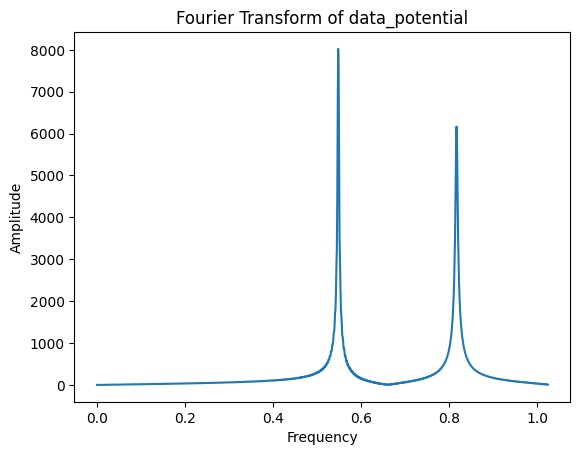

0.54779423671182 0.81708373999258 {'peak_heights': array([8020.76993132, 6165.27979207])}


In [63]:
file_path_CST_impedance = 'impedance.txt'

data_CST_impedance = np.loadtxt(file_path_CST_impedance)
plt.plot(data_CST_impedance[:, 0], np.abs(data_CST_impedance[:, 1]+1j*data_CST_impedance[:, 2]))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of data_potential')
plt.show()

peaks, peaks_height = find_peaks(np.abs(data_CST_impedance[:, 1]+1j*data_CST_impedance[:, 2]), height=1e3, threshold=None)
print(data_CST_impedance[peaks[0], 0],data_CST_impedance[peaks[1], 0] , peaks_height)

### Method for extrapolating until a given wakelength.

First try here is just to double the wakelength, thus extrapolating the wake potential by a wake function until 200m

In [14]:
new_time_extrapolate = np.linspace(GA_model_scipy.time_data[0], GA_model_scipy.time_data[-1]*2, len(GA_model_scipy.time_data)*2)

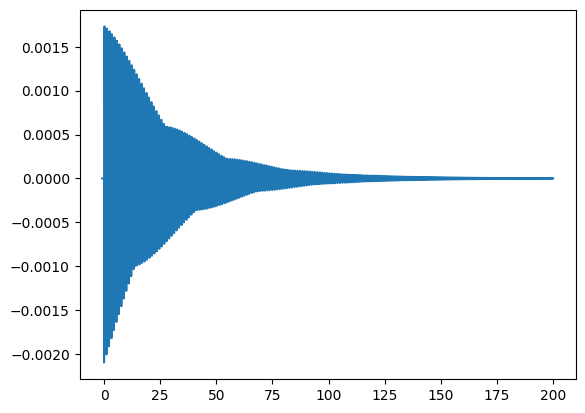

In [15]:
# Computing the wake from the fitted genetic parameters and plotting it

wake_computed = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(GA_model_scipy.geneticParameters.reshape(-1, 3))))
plt.plot(new_time_extrapolate*c_light, -2*np.pi*wake_computed*1e-15)


### Extrapolating until fully decayed
##### Parameters = {charge_param=1e-09; time_step_stability_factor=0.5; cond=1000; wakelength=10000; cpw=10}

In [53]:
# Extrapolating the wake until 240m wakelength

end_time = 240/c_light # Converting from wake length to time. 

"""The time of 240m wakelength is estimated by envelope exponential decay fitting."""

new_time_extrapolate = np.linspace(GA_model_scipy.time_data[0], end_time, int(np.round(len(GA_model_scipy.time_data)*2.4)))

In [54]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-13
wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))

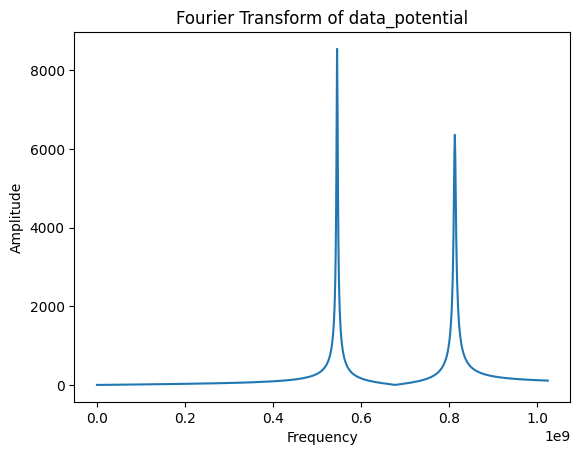

[532 793] {'peak_heights': array([8539.06547887, 6353.66215315])}


In [56]:
# Import charge data
file_path_charge_distance = "/home/malthera/cernbox/Documents/Accelerator Cavity results/All outputs 100cpw cond100/charge_dist_dist.txt"
CD_COND1000 = np.loadtxt(file_path_charge_distance)/100

# Example usage:
impedance, freq_masked, peaks, peaks_height = compute_impedance(wake_extrapolated, CD_COND1000, data_wake)
print(peaks, peaks_height)


## WAKIS

Calculating longitudinal impedance Z...


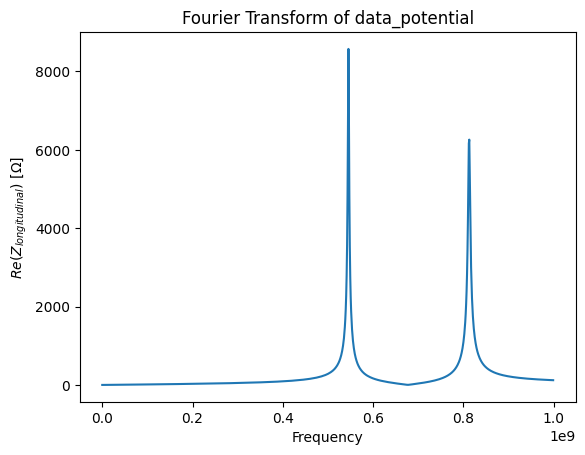

545312763.0594455 812975437.9677448 {'peak_heights': array([8576.0037095 , 6260.42500514])}


In [64]:
#instantiating a class. An instance of the WakeSolver class.
wake_function_wakis = WakeSolver(q = 1e-9, sigmaz = 0.1)

#setting the wake potential and time data

wake_function_wakis.WP = wake_extrapolated[:, 1]

wake_function_wakis.s = data_wake[:,0] /100 #GOOD

wake_function_wakis.lambdas = np.interp(data_wake[:, 0], CD_COND1000[:, 0], CD_COND1000[:, 1] / 1e-9 *1e3)

# Computing the impedance using the WakeSolver class and plotting the result

wake_function_wakis.calc_long_Z(samples = 1001)
plt.plot(wake_function_wakis.f, np.abs(wake_function_wakis.Z))
plt.xlabel('Frequency')
plt.ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
plt.title('Fourier Transform of data_potential')
plt.show()

peaks, peaks_height = find_peaks(np.abs(wake_function_wakis.Z), height=1e3, threshold=None)
print(wake_function_wakis.f[peaks[0]],wake_function_wakis.f[peaks[1]] , peaks_height)

0.54779423671182 0.81708373999258 {'peak_heights': array([8412.92361578, 6191.2197285 ])}


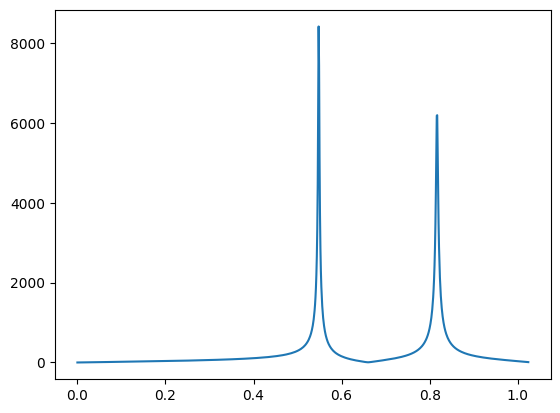

In [65]:
file_path_CST_impedance = 'impedance_240m_fullydecayed.txt'

data_CST_impedance = np.loadtxt(file_path_CST_impedance)
plt.plot(data_CST_impedance[:, 0], np.abs(data_CST_impedance[:, 1]+1j*data_CST_impedance[:, 2]))

peaks, peaks_height = find_peaks(np.abs(data_CST_impedance[:, 1]+1j*data_CST_impedance[:, 2]), height=1e3, threshold=None)
print(data_CST_impedance[peaks[0], 0],data_CST_impedance[peaks[1], 0] , peaks_height)

# Parameters = {charge_param=1e-09; cond=10000; wakelength=12000; cpw=10}

In [21]:
# Importing impedance data
data_impedance = np.loadtxt('impedance_120m_partiallydecayed_cond1e4.txt', comments='#', delimiter='\t')
frequency = data_impedance[:,0]*1e9
impedance = data_impedance[:,1] + 1j*data_impedance[:,2]

# Importing wake data
data_wake = np.loadtxt('wake_120m_partiallydecayed_cond1e4.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]/100
time = np.array(data_wake[:,0])*1e-2/c_light

In [22]:
Nres = 2

bounds = [(10e3, 20e3), (100, 2e3), (0.5e9, 0.9e9)] # 
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=120)

In [23]:
%%time
GA_model_scipy = GeneticAlgorithm(frequency, 
                                  impedance, 
                                  time, 
                                  wake, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredError,
                                  fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                 )

GA_model_scipy.run_geneticAlgorithm(maxiter=30000, 
                                    popsize=150, 
                                    tol=0.001, 
                                    mutation=(0.1, 0.5), 
                                    crossover_rate=0.8
                                   )
print(GA_model_scipy.warning)

Progress: [######################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.99e+04        |      551.70      |    8.180e+08     
    2     |        2.00e+04        |      441.19      |    5.489e+08     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 4.03 s, sys: 249 ms, total: 4.28 s
Wall time: 5.63 s


In [24]:
%%time
GA_model_scipy.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.99e+04        |      550.77      |    8.180e+08     
    2     |        2.69e+04        |      628.41      |    5.489e+08     
----------------------------------------------------------------------
CPU times: user 77.9 ms, sys: 914 µs, total: 78.8 ms
Wall time: 78.5 ms


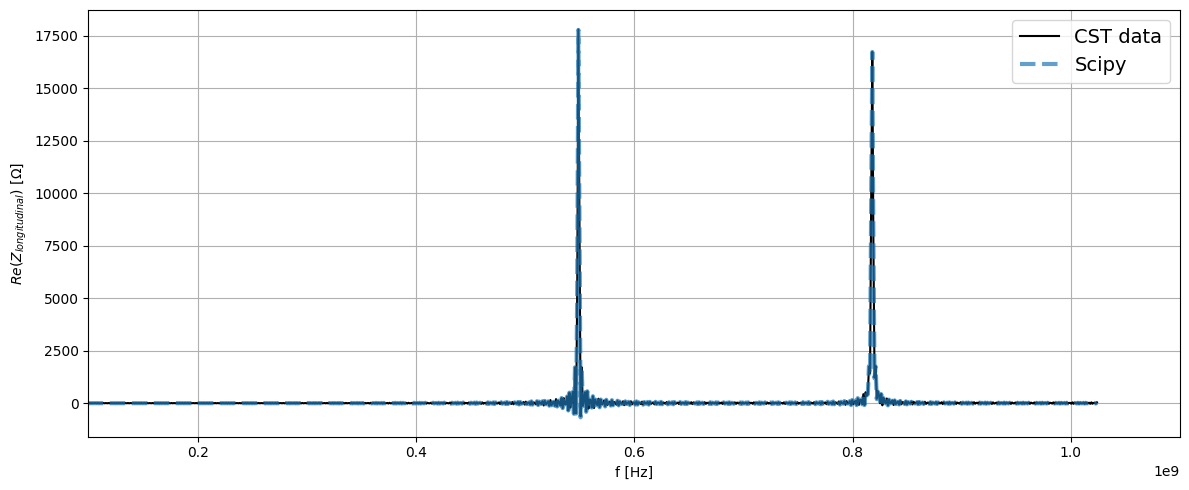

In [25]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.fitFunction(GA_model_scipy.frequency_data, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

In [26]:
# Extrapolating the wake until 600m wakelength

end_time = 599.99984253172/c_light # Converting from wake length to time

new_time_extrapolate = np.linspace(GA_model_scipy.time_data[0], end_time, int(np.round(len(GA_model_scipy.time_data)*5)))

In [27]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-13
wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))

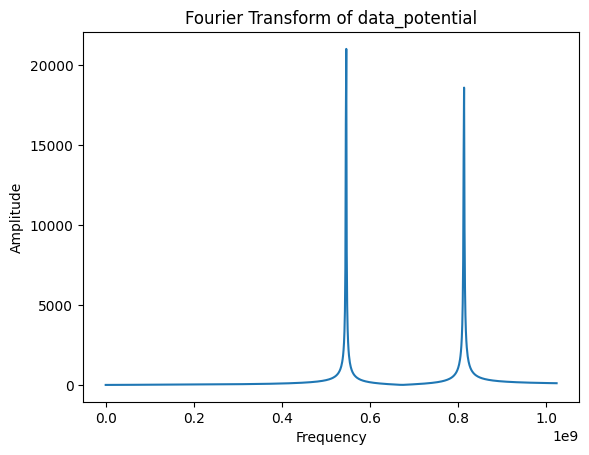

[533 794] {'peak_heights': array([21020.63145651, 18599.57384201])}


In [28]:
# Import charge data
file_path_charge_distance = "/home/malthera/cernbox/Documents/Accelerator Cavity results/All outputs 100cpw cond100/charge_dist_dist.txt"
CD_COND1000 = np.loadtxt(file_path_charge_distance)/100

# Example usage:
impedance, freq_masked, peaks, peaks_height = compute_impedance(wake_extrapolated, CD_COND1000, data_wake)
print(peaks, peaks_height)


## WAKIS

Calculating longitudinal impedance Z...


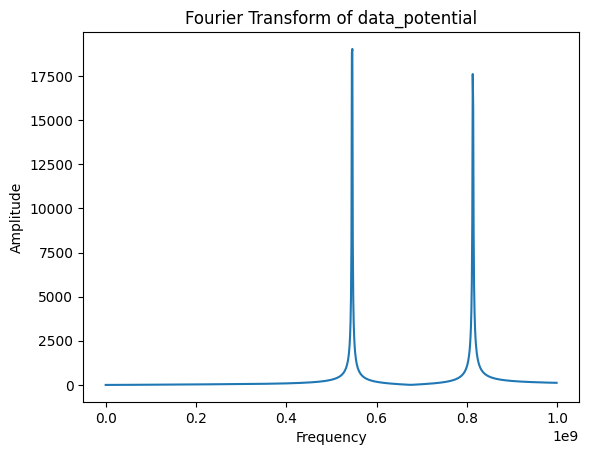

{'peak_heights': array([19029.48247744, 17607.26638639])}


In [29]:
#instantiating a class. An instance of the WakeSolver class.
wake_function_wakis = WakeSolver(q = 1e-9, sigmaz = 0.1)

#setting the wake potential and time data

wake_function_wakis.WP = wake_extrapolated[:, 1]

wake_function_wakis.s = data_wake[:,0] /100 #GOOD

wake_function_wakis.lambdas = np.interp(data_wake[:, 0], CD_COND1000[:, 0], CD_COND1000[:, 1] / 1e-9 *1e3)

# Computing the impedance using the WakeSolver class and plotting the result

wake_function_wakis.calc_long_Z(samples = 1001)
plt.plot(wake_function_wakis.f, np.abs(wake_function_wakis.Z))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fourier Transform of data_potential')
plt.show()

peaks, peaks_height = find_peaks(np.abs(wake_function_wakis.Z), height=1e3, threshold=None)
print(peaks_height)

(array([536, 799]), {'peak_heights': array([26027.2182237 , 19725.67293468])})

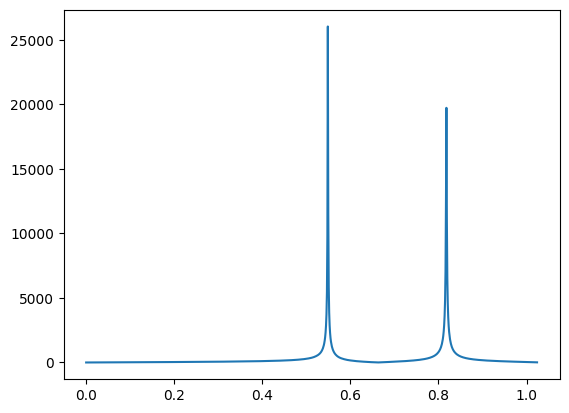

In [30]:
file_path_CST_impedance = 'impedance_600m_fullydecayed_cond1e4.txt'

data_CST_impedance = np.loadtxt(file_path_CST_impedance)
plt.plot(data_CST_impedance[:, 0], np.abs(data_CST_impedance[:, 1]+1j*data_CST_impedance[:, 2]))

peaks, peaks_height = find_peaks(np.abs(data_CST_impedance[:, 1]+1j*data_CST_impedance[:, 2]), height=1e3, threshold=None)
peaks, peaks_height

##### Parameters = {charge_param=1e-09; time_step_stability_factor=0.5; cond=1e5; wakelength=12000; cpw=10}

In [31]:
# Importing impedance data
data_impedance = np.loadtxt('impedance_120m_partiallydecayed_cond1e5.txt', comments='#', delimiter='\t')
frequency = data_impedance[:,0]*1e9
impedance = data_impedance[:,1] + 1j*data_impedance[:,2]

# Importing wake data
data_wake = np.loadtxt('wake_120m_partiallydecayed_cond1e5.txt', comments='#', delimiter='\t')
wake = data_wake[:,1]/100
time = np.array(data_wake[:,0])*1e-2/c_light

In [32]:
Nres = 2

""" Bounds on resonators parameters, it's possible to manually set them as well.
Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """

bounds = [(20e3, 30e3), (10, 5e3), (0.5e9, 0.9e9)] # 
parameterBounds = Nres * bounds

n_Resonator_longitudinal_partial_decay_imp = partial(n_Resonator_longitudinal_imp, wake_length=120)

In [33]:
%%time
GA_model_scipy = GeneticAlgorithm(frequency, 
                                  impedance, 
                                  time, 
                                  wake, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredError,
                                  fitFunction=n_Resonator_longitudinal_partial_decay_imp
                                 )

GA_model_scipy.run_geneticAlgorithm(maxiter=30000, 
                                    popsize=150, 
                                    tol=0.001, 
                                    mutation=(0.1, 0.5), 
                                    crossover_rate=0.8
                                   )
print(GA_model_scipy.warning)

Progress: [####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        3.00e+04        |      588.27      |    5.492e+08     
    2     |        3.00e+04        |      729.18      |    8.185e+08     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 3.59 s, sys: 237 ms, total: 3.83 s
Wall time: 5.03 s


In [34]:
%%time
GA_model_scipy.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        4.49e+04        |      882.41      |    5.492e+08     
    2     |        4.49e+04        |     1093.76      |    8.185e+08     
----------------------------------------------------------------------
CPU times: user 118 ms, sys: 893 µs, total: 119 ms
Wall time: 119 ms


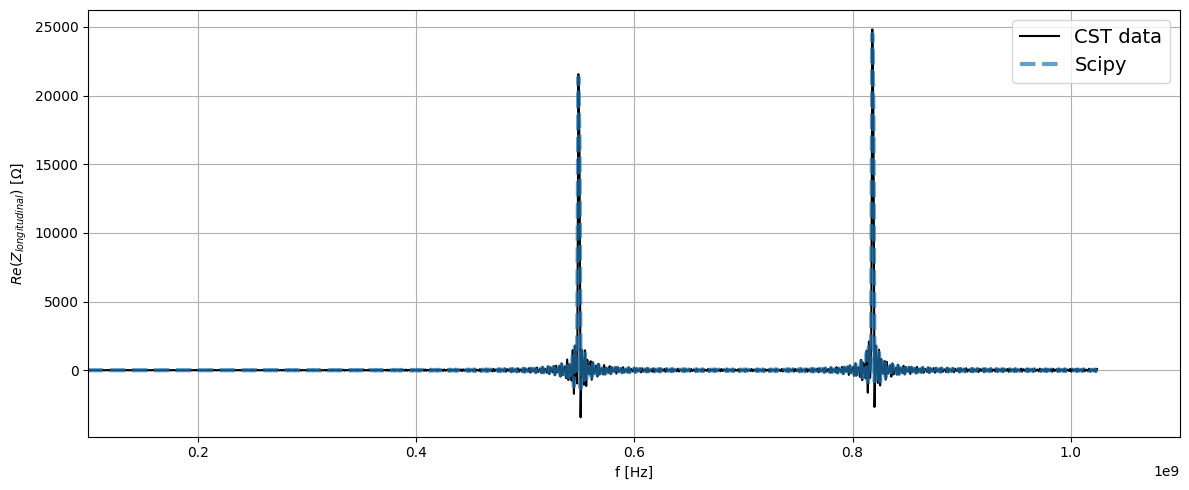

In [35]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy.frequency_data, GA_model_scipy.fitFunction(GA_model_scipy.frequency_data, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='Scipy', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

In [36]:
# Extrapolating the wake until 600m wakelength

file_path_charge_distance = "wake_2000m_fullydecayed_cond1e5.txt"
wake_fully_decayed = np.loadtxt(file_path_charge_distance)/100

end_time = wake_fully_decayed[-1][0]/c_light # Converting from wake length to time

new_time_extrapolate = np.linspace(GA_model_scipy.time_data[0], end_time, int(np.round(len(GA_model_scipy.time_data)*(2000/120))))

In [37]:
# Compute the longitudinal wake function of the two resonators

wake_extrapolated = n_Resonator_longitudinal_wake(new_time_extrapolate, dict(enumerate(GA_model_scipy.minimizationParameters.reshape(-1, 3))))*1e-16
wake_extrapolated = np.column_stack((new_time_extrapolate, wake_extrapolated))

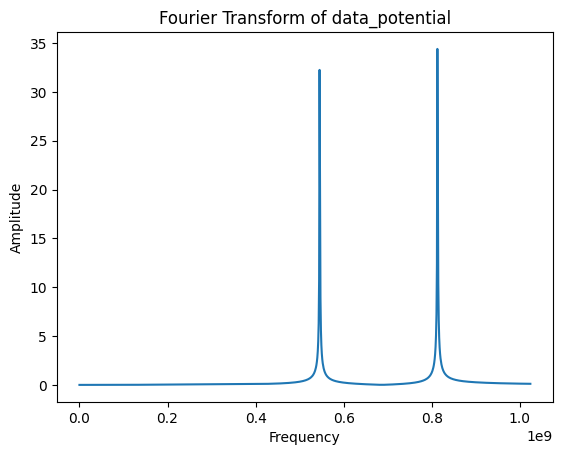

[] {'peak_heights': array([], dtype=float64)}


In [38]:
# Import charge data
file_path_charge_distance = "/home/malthera/cernbox/Documents/Accelerator Cavity results/All outputs 100cpw cond100/charge_dist_dist.txt"
CD_COND1000 = np.loadtxt(file_path_charge_distance)/100

# Example usage:
impedance, freq_masked, peaks, peaks_height = compute_impedance(wake_extrapolated, CD_COND1000, data_wake)
print(peaks, peaks_height)


(array([536, 799]), {'peak_heights': array([28941.19838978, 34482.96551533])})

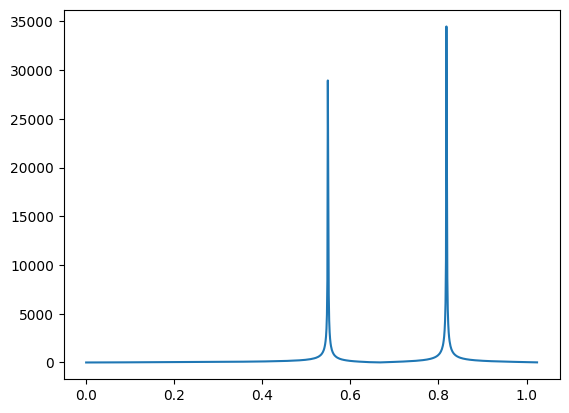

In [39]:
file_path_CST_impedance = 'impedance_2000m_fullydecayed_cond1e5.txt'

data_CST_impedance = np.loadtxt(file_path_CST_impedance)
plt.plot(data_CST_impedance[:, 0], np.abs(data_CST_impedance[:, 1]+1j*data_CST_impedance[:, 2]))

peaks, peaks_height = find_peaks(np.abs(data_CST_impedance[:, 1]+1j*data_CST_impedance[:, 2]), height=1e3, threshold=None)
peaks, peaks_height